In [1]:
import torch
from torchvision import transforms, datasets
import cv2
import numpy as np
import json
import os
from torch.utils.data import Dataset
import torch.nn as nn
from torch import optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from TuSimpleDataset import TuSimpleDataset

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [3]:
training_parameters = {
    "batch_size": 32,
}

In [16]:
data_dir = "../data/archive/TUSimple/train_set"
label_files = ["../data/archive/TUSimple/train_set/label_data_0601.json", "../data/archive/TUSimple/train_set/label_data_0313.json"]
annotation_files = ['../data/archive/TUSimple/att_train_set_0601.json', '../data/archive/TUSimple/att_train_set_0313-2.json', '../data/archive/TUSimple/att_train_set_0313-1.json']
num_categories = 4


data_loader = torch.utils.data.DataLoader(
  TuSimpleDataset(image_dir=data_dir, label_files=label_files, annotation_files=annotation_files),
  batch_size=training_parameters["batch_size"], shuffle=True, num_workers=10, persistent_workers=True)

mask_sam/0601/1494453497604532231/20.jpg
mask_sam/0601/1494453503601902751/20.jpg
mask_sam/0601/1494453509599288720/20.jpg
mask_sam/0601/1494453515596795530/20.jpg
mask_sam/0601/1494453521596643824/20.jpg
mask_sam/0601/1494453527591367337/20.jpg
mask_sam/0601/1494453533590270210/20.jpg
mask_sam/0601/1494453539586188022/20.jpg
mask_sam/0601/1494453545585907063/20.jpg
mask_sam/0601/1494453551580996478/20.jpg
mask_sam/0601/1494453557578299956/20.jpg
mask_sam/0601/1494453563575744757/20.jpg
mask_sam/0601/1494453569573067938/20.jpg
mask_sam/0601/1494453575572346547/20.jpg
mask_sam/0601/1494453581567767982/20.jpg
mask_sam/0601/1494453587565069969/20.jpg
mask_sam/0601/1494453593562528307/20.jpg
mask_sam/0601/1494453599561987554/20.jpg
mask_sam/0601/1494453605557268031/20.jpg
mask_sam/0601/1494453611554664747/20.jpg
mask_sam/0601/1494453617553424930/20.jpg
mask_sam/0601/1494453623549421445/20.jpg
mask_sam/0601/1494453629547675743/20.jpg
mask_sam/0601/1494453635544157546/20.jpg
mask_sam/0601/14

torch.Size([32, 3, 128, 128])


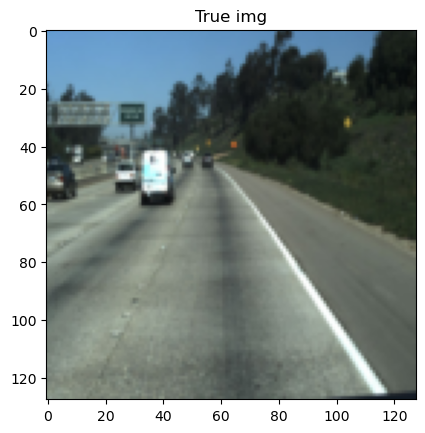

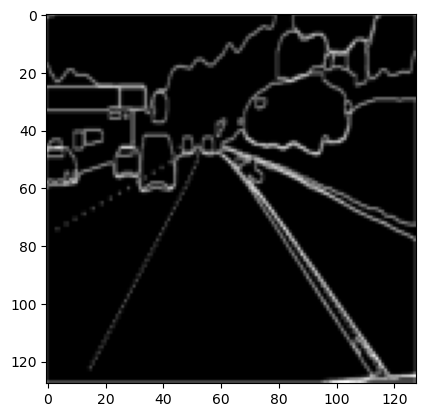

torch.Size([32, 49152])


In [7]:
for batch_idx, data_input in enumerate(data_loader):
    imgs, mask, category = data_input
    print(imgs.shape)
    plt.imshow(imgs[0].permute(1,2,0))
    plt.title('True img')
    plt.show()
    plt.imshow(mask[0].permute(1,2,0), cmap='gray')
    plt.show()
    print(mask.flatten(1).shape)
    break

In [8]:
embed_size = 128

# Define the Generator

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class UNetBottleneck(nn.Module):
    def __init__(self, size, dropout=0.0):
        super(UNetBottleneck, self).__init__()
        # Bottleneck layers
        layers = [
            nn.Conv2d(size, size, 3, 1, 1, bias=False),
            nn.BatchNorm2d(size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class GeneratorUNet(nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()

        # self.embedding = nn.Embedding(num_categories, 128 * 128)

        self.down1 = UNetDown(3, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256, dropout=0.5)
        self.down4 = UNetDown(256, 512, normalize=False, dropout=0.5)
        # self.down5 = UNetDown(512, 512, normalize=False, dropout=0.5)
        self.botl1 = UNetBottleneck(512, dropout=0.5)
        self.botl2 = UNetBottleneck(512, dropout=0.5)
        self.up1 = UNetUp(512, 256, dropout=0.5)
        self.up2 = UNetUp(512, 128)
        self.up3 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, category):
        # category_embedding = self.embedding(category)
        # category_embedding = category_embedding.view(x.shape[0], 1, 128, 128)
        # x = torch.cat([x, category_embedding], 1)

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        b1 = self.botl1(d4)
        b2 = self.botl2(b1)
        u1 = self.up1(b2, d3)
        u2 = self.up2(u1, d2)
        u3 = self.up3(u2, d1)
        return self.final(u3)


# Define the Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 2048, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(2048, 1, 4, padding=1)
        )

    def forward(self, img_A, img_B, category):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input).flatten(1)


In [14]:
num_epochs = 300
lambda_pixel = 100

discriminator_update_ratio = 0.2  # Update discriminator on 50% of the iterations
discriminator_update_step = 10
update_counter = 0

In [18]:
current_time = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(f'runs/pix2pix_SAM_{current_time}')
# Initialize the models
netG = GeneratorUNet().to(device)
netD = Discriminator().to(device)

# Losses
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixelwise = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training

for epoch in range(num_epochs):
    loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
    # writer.add_scalar('Loss/Generator', loss_G.item(), epoch)
    # writer.add_scalar('Loss/Discriminator', loss_D.item(), epoch)
    for i, batch in loop:


        # Model inputs
        category = batch[2].to(device)
        real_A = batch[1].to(device)
        real_B = batch[0].to(device)
        # # Adversarial ground truths
        valid = (torch.ones((real_A.size(0), 1), requires_grad=False)*0.9).to(device)
        fake = (torch.zeros((real_A.size(0), 1), requires_grad=False)+0.1).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        fake_B = netG(real_A, category)

        # GAN loss
        pred_fake = netD(fake_B, real_A, category)
        # pred_fake = netD(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        loss_G.backward()
        optimizer_G.step()
        update_counter += 1
        # ---------------------
        #  Train Discriminator
        # ---------------------

        if update_counter % discriminator_update_step == 0:
            optimizer_D.zero_grad()
            # pred_real = netD(real_B, real_A)
            # condition
            pred_real = netD(real_B, real_A, category)
            loss_real = criterion_GAN(pred_real, valid)
            pred_fake = netD(fake_B.detach(), real_A, category)
            loss_fake = criterion_GAN(pred_fake, fake)
            loss_D = 0.5 * (loss_real + loss_fake)
            loss_D.backward()
            optimizer_D.step()
        else:
            loss_D = torch.tensor(0)  # For logging purposes
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(G_loss=loss_G.item(), D_loss=loss_D.item())
    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            test_mask = next(iter(data_loader))[1]
            test_mask = test_mask.to(device)
            test_category = torch.randint(0, 4, (1,)).to(device)
            test_gen_img = netG(test_mask, test_category)
            for j in range(len(test_gen_img)):
                img_name = f'Generated Images'
                # category_text = f'Category: {test_category[j].item()}'
                mask_to_display = test_mask[j]
                img_name_mask = f'Masks'
                writer.add_image(img_name_mask, mask_to_display, epoch)
                writer.add_image(img_name, test_gen_img[j], epoch)
                # writer.add_text(img_name, category_text, epoch)
    writer.add_scalar('Loss/Generator', loss_G.item(), epoch)
    writer.add_scalar('Loss/Discriminator', loss_D.item(), epoch)


Epoch [300/300]: 100%|██████████| 56/56 [00:08<00:00,  6.26it/s, D_loss=0, G_loss=8.17]    


In [20]:
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((128, 128)),  # Resize the image
                transforms.ToTensor(),  # Convert to tensor
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (optional)
            ])
mask_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((128, 128)),
                transforms.ToTensor()  # Only resizing and converting to tensor, no normalization
            ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


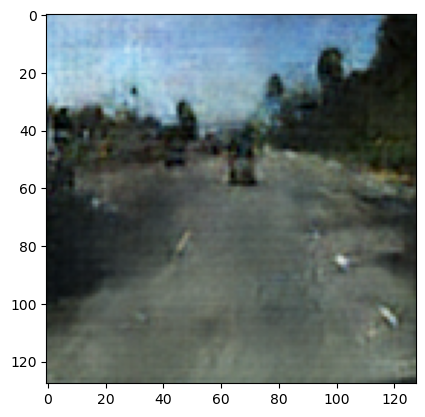

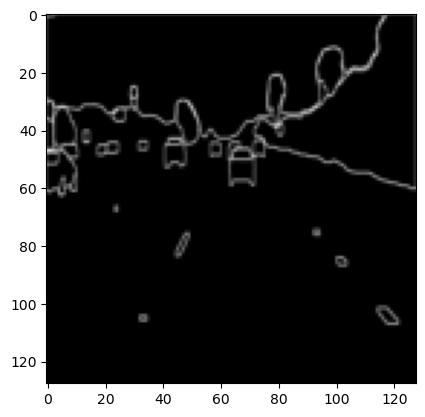

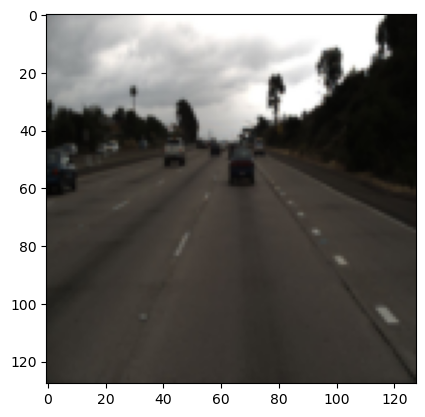

In [25]:
test_img = cv2.imread('test_images/10001/5.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_mask = cv2.imread('mask_sam_test/10001/5.jpg')

test_img = transform(test_img).unsqueeze(0).to(device)
test_mask = mask_transform(test_mask).unsqueeze(0).to(device)

test_img.shape, test_mask.shape
with torch.no_grad():
    test_gen_custom = netG(test_mask, 0)[0]

plt.imshow(test_gen_custom.permute(1,2,0).cpu())
plt.show()
plt.imshow(test_mask[0].permute(1,2,0).cpu())
plt.show()
plt.imshow(test_img[0].cpu().permute(1,2,0))


In [18]:
# Save Generator
torch.save(netG, 'saved_models/GAN/generator_model.pth')

# Save Discriminator
torch.save(netD, 'saved_models/GAN/discriminator_model.pth')

In [71]:
# Load the entire models
loadedG = torch.load('saved_models/GAN/generator_model.pth')
loadedD = torch.load('saved_models/GAN/discriminator_model.pth')

# If using a GPU
loadedG = loadedG.to(device)
loadedD = loadedD.to(device)
